# simple NN

In [7]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import networkx as nx
import numpy as np
from itertools import combinations

# Define the function to check for Laman's conditions
def is_laman_graph(G, HT):
    nV = G.number_of_nodes()
    nE = G.number_of_edges()
    if (HT-1) * nE != HT * nV - (HT + 1):
        return False
    for k in range(2, nV + 1):
        for sub_nodes in combinations(G.nodes(), k):
            if (HT-1) * G.subgraph(sub_nodes).number_of_edges() + (HT + 1) > HT * k:
                return False
    return True

# Generate features and labels for the dataset
def generate_features_labels(num_graphs, num_nodes, HT):
    features = []
    labels = []
    for _ in range(num_graphs):
        G = nx.gnm_random_graph(num_nodes, int((HT * num_nodes - (HT + 1)) / (HT - 1)))
        if nx.is_connected(G):  # Ensure the graph is connected
            feature = np.array([num_nodes, G.number_of_edges(), np.mean(list(dict(G.degree()).values()))])
            label = is_laman_graph(G, HT)
            features.append(feature)
            labels.append(int(label))
    return np.array(features), np.array(labels)

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, num_features):
        super(SimpleNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.round()
    correct = (predicted == y_true).float()  # convert into float for division 
    accuracy = correct.sum() / len(correct)
    return accuracy

In [10]:
def main():
    HT = 2
    num_graphs_per_node_count = 500  # Increase the number of graphs for a larger dataset
    num_nodes_list = [7, 8]  # You can add more node counts if desired

    all_features = []
    all_labels = []

    for num_nodes in num_nodes_list:  # Iterate over each node count
        features, labels = generate_features_labels(num_graphs_per_node_count, num_nodes, HT)
        all_features.extend(features)
        all_labels.extend(labels)

    features_tensor = torch.tensor(all_features, dtype=torch.float32)
    labels_tensor = torch.tensor(all_labels, dtype=torch.float32).unsqueeze(1)  # Adjust shape for BCELoss

    dataset = TensorDataset(features_tensor, labels_tensor)

    # Split the dataset into training, validation, and test sets
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model, loss, and optimizer
    model = SimpleNN(num_features=3)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    epochs = 200
    for epoch in range(epochs):
        model.train()
        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch_features, batch_labels in val_loader:
                outputs = model(batch_features)
                val_loss += criterion(outputs, batch_labels).item()
            print(f'Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}')

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_accuracy = 0
        for batch_features, batch_labels in test_loader:
            outputs = model(batch_features)
            test_accuracy += calculate_accuracy(batch_labels, outputs)
        print(f'Test Accuracy: {test_accuracy / len(test_loader)}')

if __name__ == "__main__":
    main()

Epoch 1, Validation Loss: 0.6990487337112427
Epoch 2, Validation Loss: 0.6888023912906647
Epoch 3, Validation Loss: 0.6892675995826721
Epoch 4, Validation Loss: 0.6920041620731354
Epoch 5, Validation Loss: 0.6943151175975799
Epoch 6, Validation Loss: 0.6880115151405335
Epoch 7, Validation Loss: 0.7006350159645081
Epoch 8, Validation Loss: 0.688899290561676
Epoch 9, Validation Loss: 0.6907715976238251
Epoch 10, Validation Loss: 0.6947333514690399
Epoch 11, Validation Loss: 0.7107136011123657
Epoch 12, Validation Loss: 0.6960402309894562
Epoch 13, Validation Loss: 0.6956754922866821
Epoch 14, Validation Loss: 0.7057229995727539
Epoch 15, Validation Loss: 0.7075393855571747
Epoch 16, Validation Loss: 0.7075139224529267
Epoch 17, Validation Loss: 0.6971348345279693
Epoch 18, Validation Loss: 0.6930538952350617
Epoch 19, Validation Loss: 0.7001138091087341
Epoch 20, Validation Loss: 0.7039135098457336
Epoch 21, Validation Loss: 0.7069520890712738
Epoch 22, Validation Loss: 0.692417633533477

# Graph Neural Network

## set up

In [1]:
import torch
print(torch.__version__)

2.2.1


In [2]:
import sys
print(sys.executable)

/Users/user/anaconda3/envs/pyg_env/bin/python


In [3]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx
import networkx as nx
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def visualize_graph(data):
    # Convert PyG graph to a NetworkX graph
    G = to_networkx(data, to_undirected=True)
    
    # Draw the graph
    plt.figure(figsize=(3, 3))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='k', linewidths=1, font_size=15, arrows=True)
    plt.show()
def is_laman_graph(G, HT):
    nV = G.number_of_nodes()
    nE = G.number_of_edges()
    if (HT-1) * nE != HT * nV - (HT + 1):
        return False
    for k in range(2, nV + 1):
        for sub_nodes in combinations(G.nodes(), k):
            if (HT-1) * G.subgraph(sub_nodes).number_of_edges() + (HT + 1) > HT * k:
                return False
    return True

is this a Laman graph? False


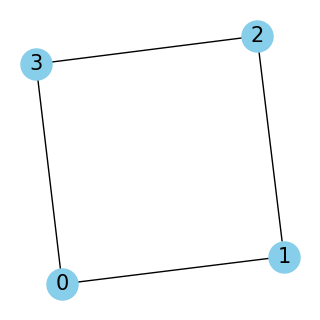

In [5]:
# Example node features: 4 nodes with 3 features each
x = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]], dtype=torch.float)
# Example edge index: 4 edges (0->1, 1->2, 2->3, 3->0)
# shape = [2, num_edges]
edge_index = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 0]], dtype=torch.long)

# Example graph data object
data = Data(x=x, edge_index=edge_index)
G = to_networkx(data, to_undirected=True)
print("is this a Laman graph? {}".format(is_laman_graph(G,2)))
visualize_graph(data)
del x, edge_index, data, G

## generate data

In [28]:
# 1 1
# 2 1
# 3 1
# 4 1
# 5 3
# 6 11
# 7 61
# 8 499
# 9 5500
# 10 75635
# 11 1237670
# 12 23352425
# 13 498028767
# 14 11836515526
# 15 310152665647
# https://oeis.org/A273468

In [31]:
def generate_graph_data(num_graphs, num_nodes, HT):
    data_list = []
    progress_interval = num_graphs // 10  # Calculate the progress interval for 10% completion
    
    for i in range(num_graphs):
        G = nx.gnm_random_graph(num_nodes, int((HT * num_nodes - (HT + 1)) / (HT - 1)))
        if nx.is_connected(G):
            degrees = np.array([d for n, d in G.degree()], dtype=np.float32).reshape(-1, 1)
            edge_index = torch.tensor(list(G.edges)).t().contiguous()
            x = torch.tensor(degrees, dtype=torch.float)  # define features as node degrees
            y = torch.tensor([is_laman_graph(G, HT)], dtype=torch.long)
            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)
        
        # Check for progress at each interval and print a message
        if (i+1) % progress_interval == 0:
            print(f"Progress: {((i+1) / num_graphs) * 100}% complete ({i+1}/{num_graphs})")

    return data_list

# Main execution
HT = 2
num_graphs = 10000  # Number of graphs to generate
num_nodes = 12  # Number of nodes per graph

# Generate graph data
# note the length of dataset is not num_graphs, since non-connected graphs are discarded.
dataset = generate_graph_data(num_graphs, num_nodes, HT)

train_size = int(num_graphs * 0.8)  # 80% of the dataset for training

# Split dataset into train and test
train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]

Progress: 10.0% complete (1000/10000)
Progress: 20.0% complete (2000/10000)
Progress: 30.0% complete (3000/10000)
Progress: 40.0% complete (4000/10000)
Progress: 50.0% complete (5000/10000)
Progress: 60.0% complete (6000/10000)
Progress: 70.0% complete (7000/10000)
Progress: 80.0% complete (8000/10000)
Progress: 90.0% complete (9000/10000)
Progress: 100.0% complete (10000/10000)


In [32]:
torch.save(dataset, 'laman_graphs_1e4dataset12nodesHT2.pt')

## Convolutional Neural Network

In [35]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(1, 16)  # 1 feature per input node
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.fc = torch.nn.Linear(64, 2)  # 2 classes: Laman or not Laman

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, data.batch)  # Aggregate to graph level
        x = self.fc(x)     # fully connected layer
        return F.log_softmax(x, dim=1)

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.NLLLoss()

loss_values = []
num_epochs = 500
# Training loop
for epoch in range(num_epochs):
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())  # Append the loss value for the epoch
    if epoch%10 ==0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.546170711517334
Epoch 11, Loss: 0.5706897377967834
Epoch 21, Loss: 0.580964207649231
Epoch 31, Loss: 0.5522387027740479
Epoch 41, Loss: 0.5649015307426453
Epoch 51, Loss: 0.5521816611289978
Epoch 61, Loss: 0.5626866817474365
Epoch 71, Loss: 0.5610319972038269
Epoch 81, Loss: 0.497200608253479
Epoch 91, Loss: 0.4448786973953247
Epoch 101, Loss: 0.43060341477394104
Epoch 111, Loss: 0.41947901248931885
Epoch 121, Loss: 0.42475977540016174
Epoch 131, Loss: 0.4265141487121582
Epoch 141, Loss: 0.4061114490032196
Epoch 151, Loss: 0.42476963996887207
Epoch 161, Loss: 0.40776610374450684
Epoch 171, Loss: 0.4276480972766876
Epoch 181, Loss: 0.43067771196365356
Epoch 191, Loss: 0.4264509379863739
Epoch 201, Loss: 0.4181208312511444
Epoch 211, Loss: 0.41742441058158875
Epoch 221, Loss: 0.4224727153778076
Epoch 231, Loss: 0.4260683059692383
Epoch 241, Loss: 0.4251709282398224
Epoch 251, Loss: 0.4279809892177582
Epoch 261, Loss: 0.4375283420085907
Epoch 271, Loss: 0.4204837083816528

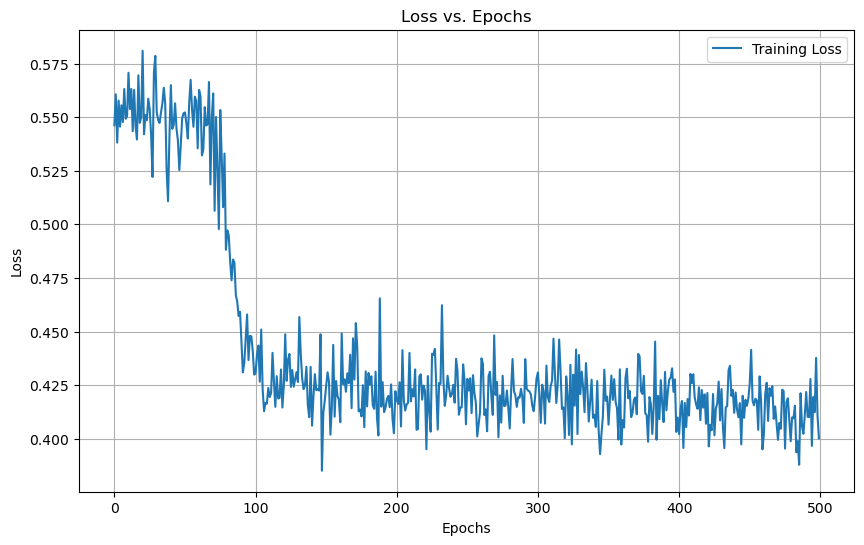

In [36]:
# Plotting
plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size
plt.plot(range(num_epochs), loss_values, label='Training Loss')  # Assumes 500 epochs
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
with torch.no_grad():  # Disable gradient computation
    for data in test_loader:
        output = model(data)
        test_loss += criterion(output, data.y).item()  # Sum up the loss
        pred = output.argmax(dim=1)  # Get the index of the max log-probability
        correct += pred.eq(data.y.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = 100. * correct / len(test_loader.dataset)
print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracy:.0f}%)\n')


Test set: Average loss: 0.4150, Accuracy: 623/804 (77%)



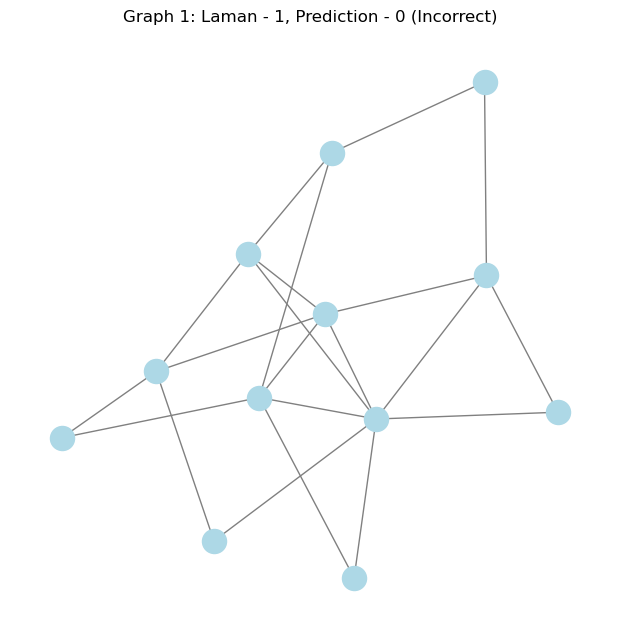

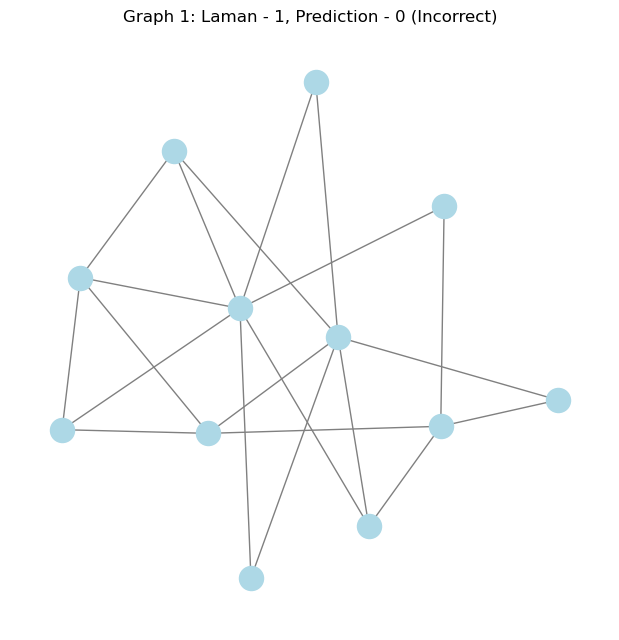

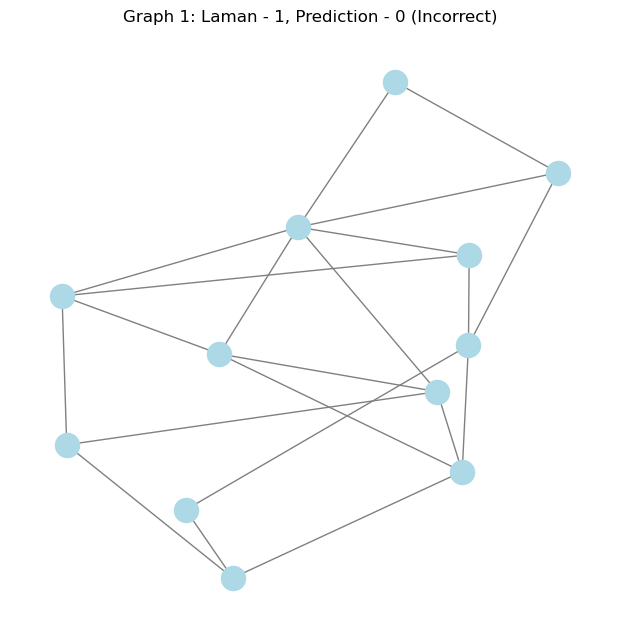

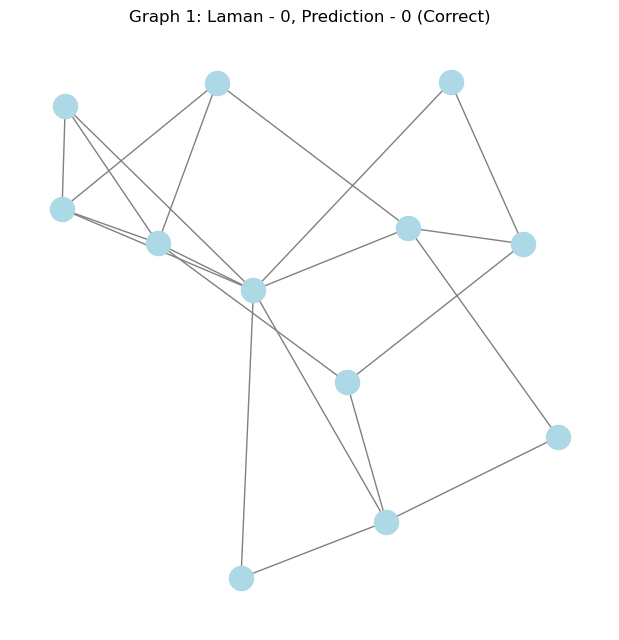

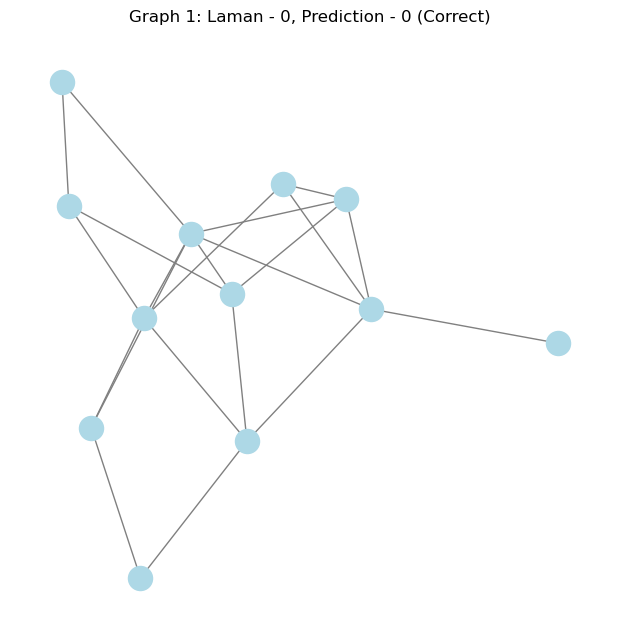

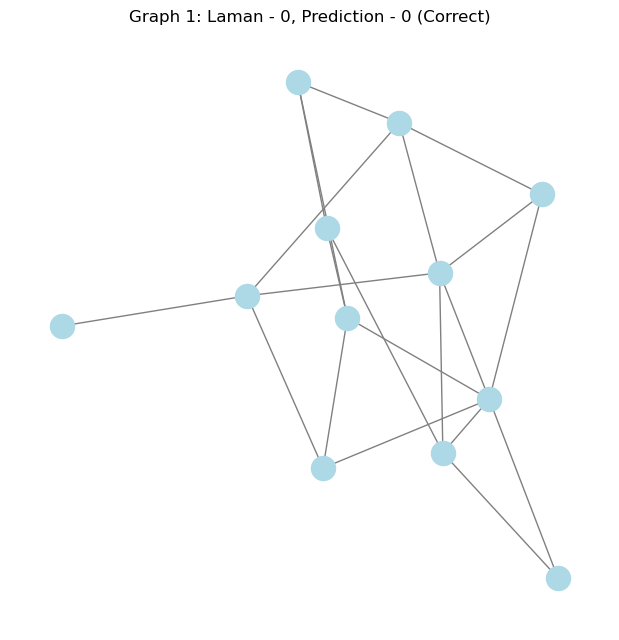

In [39]:
model.eval()  # Set the model to evaluation mode
count = 0
with torch.no_grad():  # Disable gradient computation
    for data in test_loader:
        output = model(data)
        pred = output.argmax(dim=1)  # Get the index of the max log-probability
        correct = pred.eq(data.y.view_as(pred))  # Check if predictions are correct

        # Convert data to NetworkX graph for visualization (assuming the dataset allows it)
        for i in range(len(data.y)):
            graph = to_networkx(data, to_undirected=True, remove_self_loops=True)
            label = data.y[i].item()
            prediction = pred[i].item()
            is_correct = 'Correct' if correct[i].item() else 'Incorrect'

            # Plot the graph
            plt.figure(figsize=(6, 6))
            nx.draw(graph, node_color='lightblue', edge_color='gray')
            plt.title(f'Graph {i+1}: Laman - {label}, Prediction - {prediction} ({is_correct})')
            plt.show()

            # Break after a few examples to avoid flooding the screen
            if i >= 2:  # Adjust the number based on how many examples you want to see
                break

        count += 1
        if count > 5:
            break

## GAT

In [23]:
# class GATNet(torch.nn.Module):
#     def __init__(self, num_node_features, num_classes):
#         super(GATNet, self).__init__()
#         self.conv1 = GATConv(num_node_features, 8, heads=8, dropout=0.6)
#         self.conv2 = GATConv(8 * 8, num_classes, heads=1, concat=False, dropout=0.6)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index

#         x = F.dropout(x, p=0.6, training=self.training)
#         x = F.elu(self.conv1(x, edge_index))
#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv2(x, edge_index)

#         # Use global mean pooling to aggregate node features into a graph-level feature
#         x = global_mean_pool(x, data.batch)

#         return F.log_softmax(x, dim=1)

class GATNet(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GATNet, self).__init__()
        # First GAT layer
        self.conv1 = GATConv(num_node_features, 8, heads=8, dropout=0.6)
        # Additional GAT layer(s)
        self.conv1_5 = GATConv(8 * 8, 16, heads=8, dropout=0.6)
        # Final GAT layer before classification
        self.conv2 = GATConv(16 * 8, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Initial dropout
        x = F.dropout(x, p=0.6, training=self.training)
        # First GAT layer with ELU activation
        x = F.elu(self.conv1(x, edge_index))
        # Dropout before next GAT layer
        x = F.dropout(x, p=0.6, training=self.training)
        # Additional GAT layer(s) with ELU activation
        x = F.elu(self.conv1_5(x, edge_index))  # Passing through the additional layer
        # Dropout before the final GAT layer
        x = F.dropout(x, p=0.6, training=self.training)
        # Final GAT layer
        x = self.conv2(x, edge_index)

        # Use global mean pooling to aggregate node features into a graph-level feature
        x = global_mean_pool(x, data.batch)

        return F.log_softmax(x, dim=1)

In [24]:
model = GATNet(num_node_features=1, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()
    

# Assuming dataset is already created and split into train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
loss_values = []
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())
    if epoch%10 ==0:
        print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')

Epoch: 1, Loss: 0.6416
Epoch: 11, Loss: 0.6995
Epoch: 21, Loss: 0.7830
Epoch: 31, Loss: 0.6463
Epoch: 41, Loss: 0.5630
Epoch: 51, Loss: 0.5663
Epoch: 61, Loss: 0.6135
Epoch: 71, Loss: 0.7072
Epoch: 81, Loss: 0.6521
Epoch: 91, Loss: 0.5559
Epoch: 101, Loss: 0.6821
Epoch: 111, Loss: 0.5744
Epoch: 121, Loss: 0.4738
Epoch: 131, Loss: 0.4643
Epoch: 141, Loss: 0.5649
Epoch: 151, Loss: 0.6558
Epoch: 161, Loss: 0.5094
Epoch: 171, Loss: 0.5667
Epoch: 181, Loss: 0.5987
Epoch: 191, Loss: 0.4674
Epoch: 201, Loss: 0.5990
Epoch: 211, Loss: 0.5904
Epoch: 221, Loss: 0.6608
Epoch: 231, Loss: 0.5906
Epoch: 241, Loss: 0.6013
Epoch: 251, Loss: 0.7229
Epoch: 261, Loss: 0.5340
Epoch: 271, Loss: 0.6566
Epoch: 281, Loss: 0.5296
Epoch: 291, Loss: 0.6306
Epoch: 301, Loss: 0.4632
Epoch: 311, Loss: 0.5958
Epoch: 321, Loss: 0.5340
Epoch: 331, Loss: 0.6281
Epoch: 341, Loss: 0.6344
Epoch: 351, Loss: 0.4918
Epoch: 361, Loss: 0.6282
Epoch: 371, Loss: 0.6293
Epoch: 381, Loss: 0.4261
Epoch: 391, Loss: 0.5953
Epoch: 401,

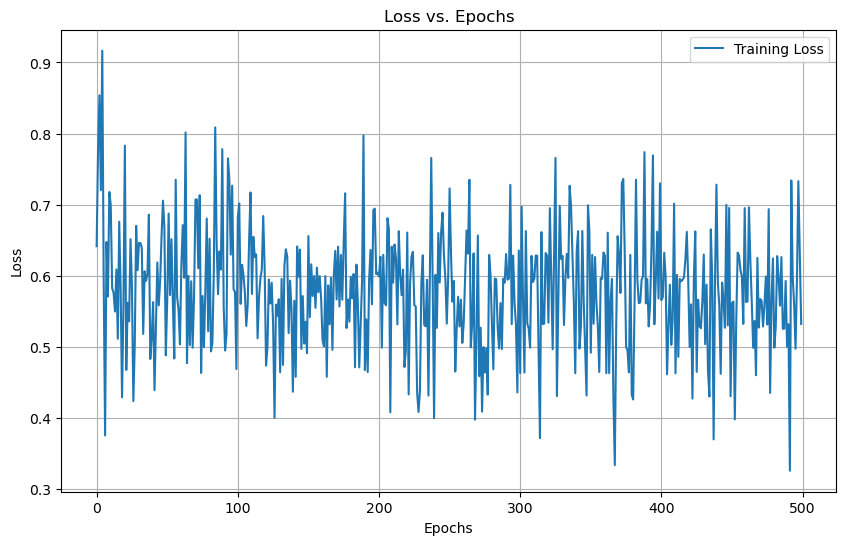

In [25]:
# Plotting
plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size
plt.plot(range( num_epochs), loss_values, label='Training Loss')  # Assumes 500 epochs
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
with torch.no_grad():  # Disable gradient computation
    for data in test_loader:
        output = model(data)
        test_loss += criterion(output, data.y).item()  # Sum up the loss
        pred = output.argmax(dim=1)  # Get the index of the max log-probability
        correct += pred.eq(data.y.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = 100. * correct / len(test_loader.dataset)
print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracy:.0f}%)\n')


Test set: Average loss: 0.5428, Accuracy: 63/82 (77%)

